# Comparision to different packages

This notebook contains a comparison of the Vietoris-Rips (VR) persistent homology (PH) computation (GPU) implemented in `chofer_torchex` to the implementations available via `dionysus` and `ripser`. It also shows how to compute VR PH in this context.

In [25]:
import sys

In [26]:
# UNCOMMENT IN CASE YOU WANT TO LOCALLY INSTALL RIPSER
# !{sys.executable} -m pip install ripser

In [27]:
# UNCOMMENT IN CASE YOU WANT TO LOCALLY INSTALL DIONYSUS
# !{sys.executable} -m pip install dionysus

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from collections import defaultdict

# UNCOMMENT TO IMPORT RIPSER and DIONYSUS
# from ripser import ripser
# import dionysus as d

import torch
import time

from scipy.spatial.distance import pdist

from sklearn import datasets

from chofer_torchex.pershom import pershom_backend
from chofer_torchex.pershom import vr_persistence_l1

device = 'cuda:0'

In [39]:
def gen_random_10D_data(n):
    return np.random.randn(n,10)  

def gen_circlces(n):
    return datasets.make_circles(n_samples=n, noise=0.05, factor=0.5)[0]

N = np.arange(50,400,50)

times = defaultdict(list)

f = gen_circlces

for n in N:
    trials = defaultdict(list)
    print('Evaluating N={}'.format(n))
    
    for i in np.arange(50):
        
        #Generate data
        x = f(n)
        D_l1 = pdist(x, metric='cityblock')
        thr_l1 = np.max(D_l1.ravel())

        X = torch.Tensor(x).to(device)
        
        # Timing chofer_torchex
        t0 = time.time()
        l, _ = vr_persistence_l1(X.contiguous(),0, 0);
        t1 = time.time()
        trials['chofer_torchex'].append(t1-t0)
        
        if 'ripser' in sys.modules:        
            t0 = time.time()
            ripser(x, maxdim=0, thresh=thr_l1, metric='manhattan')
            t1 = time.time()
            trials['ripser'].append(t1-t0)
        
        if 'dionysus' in sys.modules: 
            t0 = time.time()
            dd = pdist(x, metric='cityblock')
            filt = d.fill_rips(dd, 1, thr_l1)
            m = d.cohomology_persistence(filt)
            t1 = time.time()
            trials['dionysus'].append(t1-t0)
        
    times[n] = trials

Evaluating N=50
Evaluating N=100
Evaluating N=150
Evaluating N=200
Evaluating N=250
Evaluating N=300
Evaluating N=350


In [40]:
methods = []
if 'ripser' in sys.modules:
    methods.append('ripser')
if 'dionysus' in sys.modules:
    methods.append('dionysus')
methods.append('chofer_torchex')

T = np.zeros((len(N),3))
S = np.zeros((len(N),3))
for j,(k,v) in enumerate(times.items()):
    for i, method in enumerate(methods):
        T[j,i] = np.array(v[method]).mean()
        S[j,i] = np.array(v[method]).std()

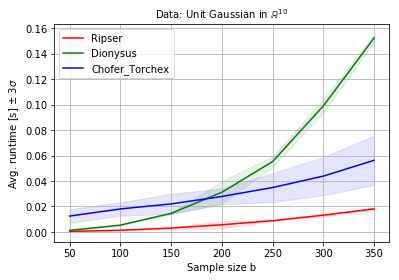

In [41]:
colors = ['red', 'green', 'blue']

plt.figure(figsize=(6,4))
for i, method in enumerate(methods):
    plt.plot(N, T[:,i], label=method.title(), color=colors[i])
    plt.fill_between(N, T[:,i]-3*S[:,i], T[:,i]+3*S[:,i], color=colors[i], alpha=0.1)
    
plt.legend()
plt.grid()
plt.xlabel('Sample size b')
plt.ylabel(r'Avg. runtime [s] $\pm$ 3$\sigma$')
plt.title(r'Data: Unit Gaussian in $\mathbb{R}^{10}$', fontsize=10)
plt.savefig('/tmp/normal10d_runtime.pdf', bbox_inches='tight')

# Sanity check
Run a simple sanity check that all VR PH computations return the same result.

In [42]:
# Sample data
x = f(200)

# Compute l1 distance matrix and get max. pairwise distance = threshold
D_l1 = pdist(x, metric='cityblock')
thr_l1 = np.max(D_l1.ravel())

# Run Ripser
dgm_ripser = ripser(x, maxdim=0, thresh=thr_l1, metric='manhattan')['dgms']

# Run Ours
X = torch.Tensor(x).to(device)
l, _ = vr_persistence_l1(X.contiguous(),0, 0);

# Run Dionysus
filt = d.fill_rips(D_l1, 1, thr_l1)
m = d.cohomology_persistence(filt)
dgms = d.init_diagrams(m, filt)

In [43]:
assert(np.abs(dgm_ripser[0][:,1][:-1] - l[0].cpu().numpy()[:,1]).sum() < 1e-5)
assert(np.abs(sorted([x.death for x in dgms[0]])[:-1] - l[0].cpu().numpy()[:,1]).sum() < 1e-5)
assert(np.abs(dgm_ripser[0][:,1][:-1] - sorted([x.death for x in dgms[0]])[:-1]).sum() < 1e-5)